<img src="../docs/sa_logo.png" width="250" align="left">

# 1. Introduction

We are going to use google's [Vertex AI](https://cloud.google.com/vertex-ai) to train an object tracking model and integrate it with the [SuperAnnotate](https://www.superannotate.com/) platform.

We will be using Kaggle's [soccer track](https://www.kaggle.com/datasets/atomscott/soccertrack) dataset. We will only use the videos taken from the top view. The steps we will cover are the following: 
1. Download and convert data to google cloud's [format](https://cloud.google.com/vertex-ai/docs/video-data/object-tracking/prepare-data?authuser=1#csv) 
2. Setup our GCP. 
3. Train an object tracking model.
4. Run predictions.
5. Convert the predictions to [superannote video format](https://doc.superannotate.com/docs/import-video-json)
6. Upload conversions and verify them on SuperAnnotate platform

# 2. Downloading and Preparing train/test data

Download the kaggle dataset and extract the "top view" folder so that you have the videos and annotations in one place. The videos folder contains the input videos. I have renamed the "annotations" folder to "input_annotations" and created an "output_annotations" folder. The latter is where we will store annotations in GCP acceptable format

In [ ]:
# To setup your environment 
!pip install google-cloud-storage==2.7.0
!pip install google-cloud-aiplatform==1.20.0
!pip install google-cloud-core==2.3.2
!pip install google-cloud-resource-manager==1.7.0
!pip install pandas==1.4.2
!pip install superannotate==4.4.8

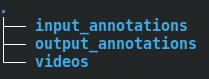

In [ ]:
from random import random
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import csv
import cv2

In [ ]:
VIDEO_BUCKET = "object_tracking_bucket" # We will store videos here
ANNOTATIONS_BUCKET  = "object_tracking_annotations" # We will store annotations here
LOCATION="us-central1" 

# The column names of the input csv-s map to these ids.
TEAM_1_LABELS = [f"team_1_player_{i}" for i in [1, 10, 11, 2, 3, 4, 5, 6, 7, 8, 9]]
TEAM_2_LABELS = [f"team_2_player_{i}" for i in [1, 10, 11, 2, 3, 4, 5, 6, 7, 8, 9]]
FULL_LABELS = [*TEAM_1_LABELS, *TEAM_2_LABELS, "Ball"]

In [ ]:
def get_video_dimensions(file_path):
    vid = cv2.VideoCapture(file_path)
    h = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
    w = vid.get(cv2.CAP_PROP_FRAME_WIDTH)
    return h, w

In [ ]:
def make_bbox(top_x, top_y, width, height, video_h, video_w):
    # GCP expects the bounding box to be of the format: 
    # top_left_x, top_left_y, top_left_x, top_right_y
    # bottom_left_x, bottom_left_y, bottom_right_x, bottom_right_y 
    # normalized relative to the height and width of the video.
    bbox = [
        top_x / video_w,
        top_y / video_h,
        (top_x+width) / video_w,
        top_y / video_h,
        (top_x+width) / video_w,
        (top_y+height) / video_h,
        top_x / video_w,
        (top_y + height)/video_h
    ]
    return bbox

In [ ]:
def convert_single_row(frame, row:pd.Series, csv_name = None)->list:
    video_name = Path(csv_name).stem+'.mp4'
    gcloud_url = f"gs://{VIDEO_BUCKET}/{video_name}" 
    timestamp = round(frame / 30, 4)
    rows = []
    video_h, video_w = get_video_dimensions(f"./data/videos/{video_name}")
    for idx, label in enumerate(FULL_LABELS):
        top_x = float(row[idx * 4])
        top_y = float(row[idx * 4 + 1])
        width = float(row[idx * 4 + 2])
        height = float(row[idx*4+3])
        
        split_decider = random()
        ml_use = "TRAINING" if split_decider > 0.2 else "TEST"
        bbox = make_bbox(top_x, top_y, width, height, video_h, video_w)
        
        new_row = [ml_use, gcloud_url, label, idx, timestamp, *bbox]
        rows.append(new_row)
    return rows

In [ ]:
def convert_single_file(path: str)->list:
    # Loading the dataframe
    df = pd.read_csv(path)
    # Dropping the confidence columns
    df = df[[k for i, k in enumerate(df.columns, 0) if i % 5 != 0]] # Every 5th column is confidence
    df = df.iloc[3:,:] # Dropping meta information. 
    # Vertex AI allows for a limited number of annotations per video, 
    # so we sample every 3rd frame in every second of the video
    df = df.iloc[::3, :]
    final_csv_rows = []
    for frame, row in df.iterrows():
        per_label_csv_rows = convert_single_row(frame, row, path)
        final_csv_rows.extend(per_label_csv_rows)
    return final_csv_rows

In [ ]:
def convert_annotations_to_gcp(root: str)->None:
    root = Path(root)
    annotations = (root/"input_annotations").glob('*') # getting all csv files
    for annotation_file in tqdm(annotations):
        new_csv = convert_single_file(annotation_file)
        with (root / "output_annotations" / annotation_file.name).open("w") as fp:
            writer = csv.writer(fp)
            writer.writerows(new_csv)


In [ ]:
convert_annotations_to_gcp("./data")

# 2. Setting up google-cloud

You will need to have installed google-cloud-cli, created a project and authenticated into your account as described in [google docs](https://cloud.google.com/run/docs)

In [1]:
from google.cloud import storage
from google import auth
gcp_credentials, _ = auth.default()

/home/vahagn/.local/lib/python3.8/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [ ]:
GOOGLE_PROJECT_NAME = "SET_YOUR_PROJECT_NAME" # Set your own project name

In [ ]:
# Creating a client
gcp_client = storage.Client(GOOGLE_PROJECT_NAME)
# Creating a bucket 
bucket = gcp_client.bucket(VIDEO_BUCKET)
if not bucket.exists():
    gcp_client.create_bucket(VIDEO_BUCKET)

annotations_bucket = gcp_client.bucket(ANNOTATIONS_BUCKET)

if not annotations_bucket.exists():
    gcp_client.create_bucket(ANNOTATIONS_BUCKET)


In [ ]:
# Upload videos to the bucket
videos = Path("./data/videos/").glob("*")
for video in tqdm(videos):
    blob = bucket.blob(video.name)
    blob.upload_from_filename(str(video))

After the upload the bucket should look like this 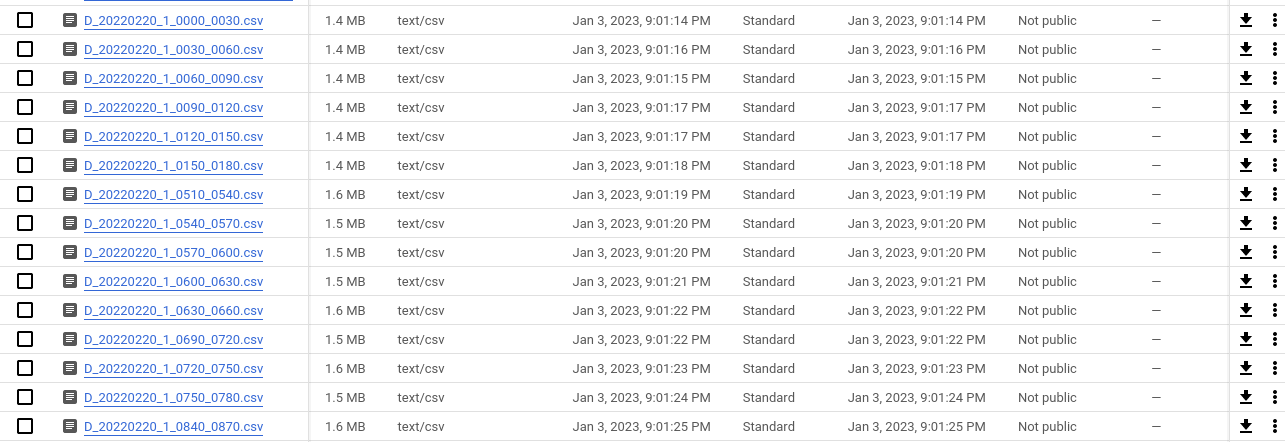

In [ ]:
# Upload annotations to the bucket
annotations = Path("../../playground/data").glob("*")
for annotation in tqdm(annotations):
    blob = annotations_bucket.blob(annotation.name)
    blob.upload_from_filename(str(annotation))

After the upload the bucket should look like this 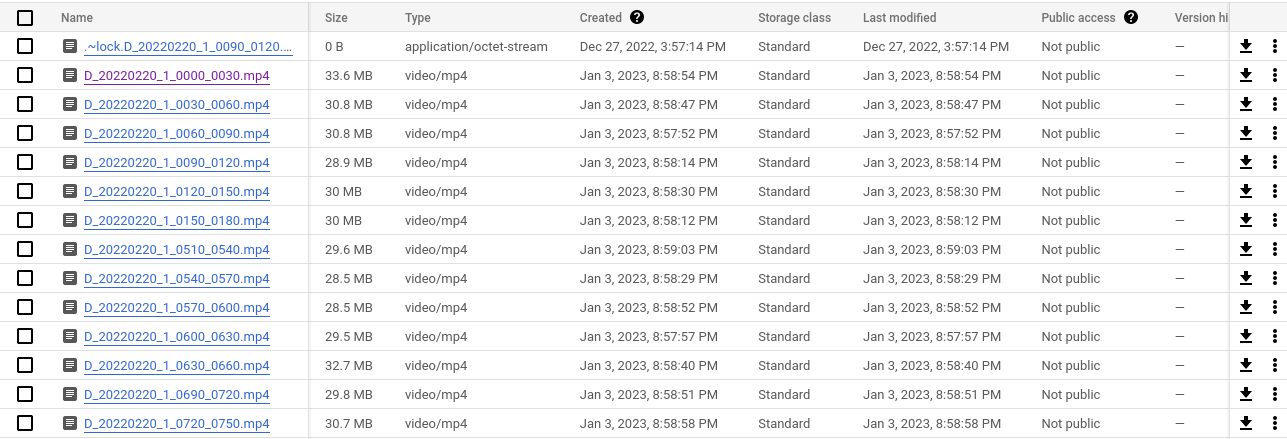

Create your AIPlatform dataset

In [ ]:
from google.cloud import aiplatform


In [ ]:
# Generate links to csv files
gcs_source = [f"gs://{ANNOTATIONS_BUCKET}/{p.name}" for p in Path("./data/output_annotations/").glob('*') if "lock" not in str(p)]

In [2]:
def create_dataset(
    project: str,
    location: str,
    display_name: str,
    sync: bool,
    gcs_source: list,
    credentials
):
    aiplatform.init(project=project, location=location, credentials=credentials)
    
    
    ds = aiplatform.VideoDataset.create(
        display_name=display_name,
        import_schema_uri=aiplatform.schema.dataset.ioformat.video.object_tracking,
        gcs_source = gcs_source,
        sync=sync,
        credentials = credentials
    )

    ds.wait()

    print(ds.display_name)
    print(ds.resource_name)
    return ds


In [ ]:
DS = create_dataset(GOOGLE_PROJECT_NAME, LOCATION, "kaggle_soccer_dataset", True, gcs_source, gcp_credentials)

After having created the dataset you can explore it in your Vertex AI console, it should look like the following image 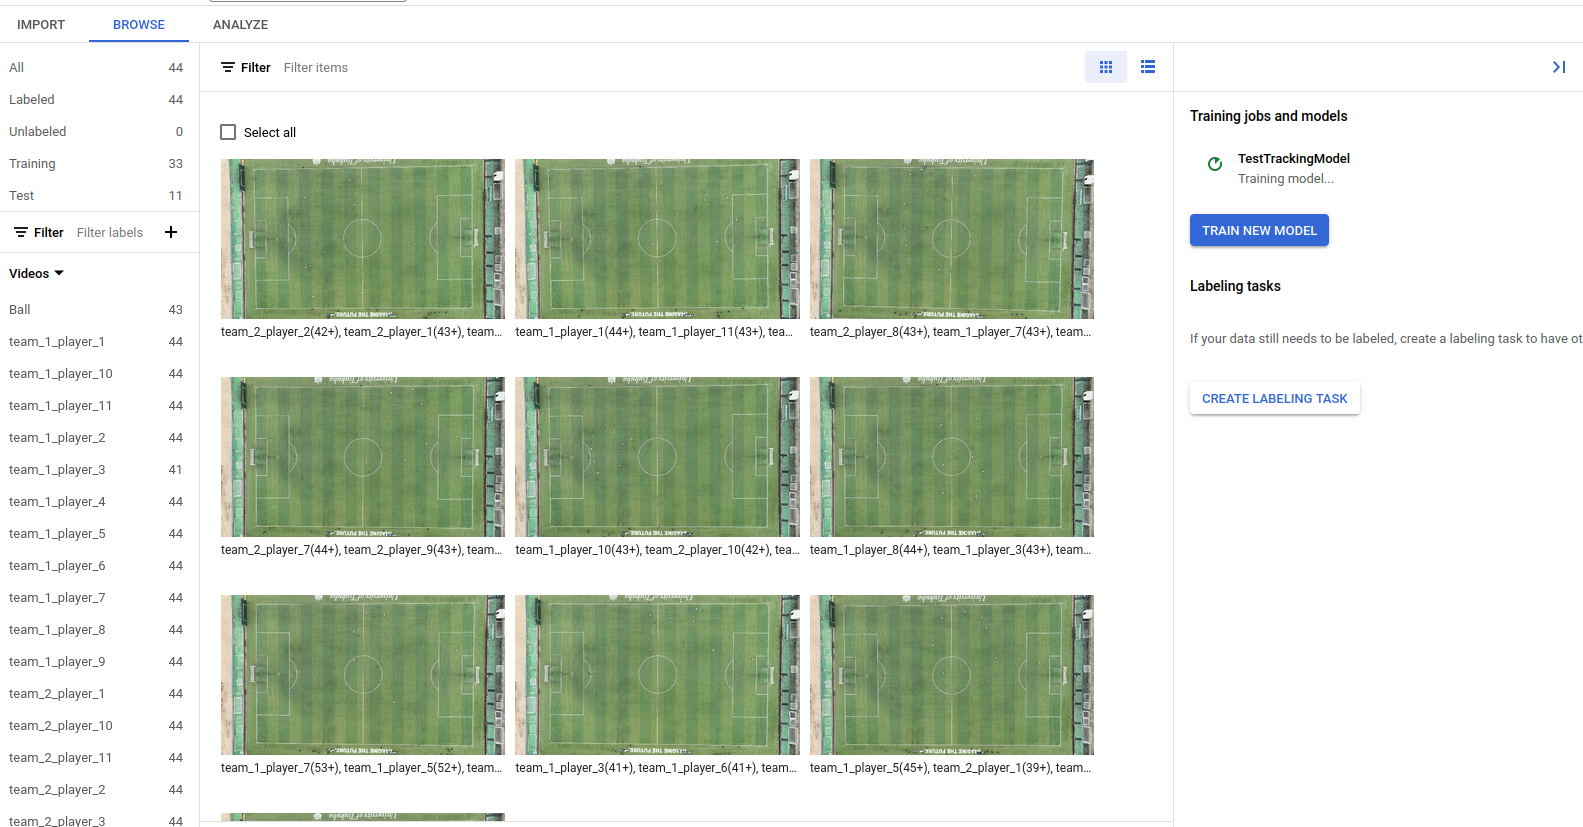

# 3. Running training and inference

In order to train an object-tracking model we need to

1. create an AutoMLVideoTrainingJob
2. Run the training
3. Wait for it to finish (This may take a very long time)

After the training is finished we can use it to predict new labels. In general GCP allows for 2 types of predictions

1. Endpoints
2. Batch predictions jobs

Online predictions are synchronous requests made to a model endpoint. Use online predictions when you are making requests in response to application input or in situations that require timely inference.

Batch predictions are asynchronous requests. You request batch predictions directly from the model resource without needing to deploy the model to an endpoint. For image data, use batch predictions when you don't require an immediate response and want to process accumulated data by using a single request. 

However for video related models only [batch predictions](https://cloud.google.com/vertex-ai/docs/video-data/object-tracking/get-predictions) are avaiable

In [ ]:
from google.cloud.aiplatform import AutoMLVideoTrainingJob
from google.cloud import aiplatform
import json

In [ ]:
aiplatform.init()

In [ ]:
# Creating the training job
job = AutoMLVideoTrainingJob(
    display_name = "TestTrackingModel",
    prediction_type = "object_tracking",
    model_type = "CLOUD",
    credentials = gcp_credentials,
    project=GOOGLE_PROJECT_NAME
)

In [ ]:
# Running the training job
model = job.run(dataset=DS) # This will take a long time and will train your model
model_resource_name = model.resource_name

If you already have trained a model you can iterate over them and take the one you want to use

In [ ]:
from google.cloud.aiplatform import Model
models = Model.list(project = GOOGLE_PROJECT_NAME)

for model in models:
    if model.display_name == "TestTrackingModel":
        model_resource_name = model.resource_name
        break

Now that the model has been created and trained we can use it to run batch predictions. 

Before we can actually start running a batch prediction we first need to create a json file that will describe the 
the prediction job. It has too look something like the following

In [ ]:
batch_params = {"content": "gs://video_test_set/D_20220220_1_0000_0030.mp4", 
                "mimeType": "video/mp4", 
                "timeSegmentStart": "0.0s", 
                "timeSegmentEnd": "3"}

we also need to upload this file to any bucket in our GCP to use it as a parameter. 

In [ ]:
# Upload batch_params to the bucket
bucket = gcp_client.bucket("video_test_set")

blob = bucket.blob("batch_params.json")
blob.upload_from_filename("./batch_params.json")

In [ ]:
def create_batch_prediction_job(
    project: str,
    location: str,
    model_resource_name: str,
    job_display_name: str,
    gcs_source: str,
    gcs_destination: str,
    sync: bool = True,
    credentials = gcp_credentials
):
    aiplatform.init(project=project, location=location)

    my_model = aiplatform.Model(model_resource_name)

    batch_prediction_job = my_model.batch_predict(
        job_display_name=job_display_name,
        gcs_source=gcs_source,
        gcs_destination_prefix=gcs_destination,
        sync=sync,
        credentials=credentials
    )

    batch_prediction_job.wait()

    print(batch_prediction_job.display_name)
    print(batch_prediction_job.resource_name)
    print(batch_prediction_job.state)
    return batch_prediction_job


In [ ]:
batch_prediction_job = create_batch_prediction_job(
    project=GOOGLE_PROJECT_NAME,
    job_display_name="batch_job",
    credentials = gcp_credentials,
    location="us-central1",
    model_resource_name=model_resource_name,
    gcs_source = "gs://video_test_set/batch_params.json", # Pick a video you want to run prediction on
    gcs_destination="gs://object_tracking_batch_output"
)

# 4. Converting predictions into SuperAnnotate format

Now that the prediction job is done we can download the json and start converting it to superannotate format. You can get the URI from the bucket you specified as gcs_destination in our case it is `gs://object_tracking_batch_output/prediction-TestTrackingModel-2023-01-13T07:28:24.002685Z/predictions_00001.jsonl`

In [ ]:
bucket = gcp_client.get_bucket("object_tracking_batch_output")
# Create a blob object from the filepath
blob = bucket.blob("prediction-TestTrackingModel-2023-01-13T07:28:24.002685Z/predictions_00001.jsonl")
# Download the file to a destination
blob.download_to_filename("predictions.json")

In [ ]:
predictions = json.load(open("./predictions.json"))

In order to not clutter our video let's take predictions that have are inside more than 10 frames

In [ ]:
predictions, inst = predictions['prediction'], predictions['instance']
predictions = [x for x in predictions if len(x["frames"]) > 10]

In [ ]:
def create_instance(prediction, meta, h ,w):
    result = {
            "start": float(meta["timeSegmentStart"][:-1]) * 1000 * 1000,
            "end": float(meta["timeSegmentEnd"][:-1]) * 1000 * 1000,
            "timestamps": [create_tstamp(frame, h, w) for frame in prediction["frames"]]
        }
    result["timestamps"][-1]["timestamp"] = 2366667.0
    return result

In [ ]:
def create_tstamp(frame, h , w):
    res = {
        "timestamp": float(frame["timeOffset"][:-1]) * 1000 * 1000,
        "attributes": [],
        "points": {
            "x1": frame["xMin"] * w,
            "y1": frame["yMin"] * h,
            "x2": frame["xMax"] * w,
            "y2": frame["yMax"] * h
        }
    }
    return res

In [ ]:
def convert_to_sa_format(predictions, instance_meta, file_name):
    h, w = get_video_dimensions(file_name)
    metadata = {
        "name": "video1.mp4",
        "width": w,
        "height": h,
        "url": "https://storage.cloud.google.com/video_test_set/D_20220220_1_0000_0030.mp4",
    }
    instances = []
    for prediction in predictions:
        new_instance = {
            "meta": {
                "className" : prediction["displayName"],
                "type": "bbox",
                "creationType":"Manual",
                "start": float(instance_meta["timeSegmentStart"][:-1]) * 1000 * 1000,
                "end": float(instance_meta["timeSegmentEnd"][:-1]) * 1000 * 1000
            } ,
            "parameters": []
        }
        
        new_instance["parameters"].append(create_instance(prediction, instance_meta, h, w))
        instances.append(new_instance)
        
    annotation = {
        "metadata" : metadata,
        "instances": instances,
        "tags": []
    }
    return annotation

In [ ]:
annotation_json = convert_to_sa_format(predictions, inst, "./data/videos/D_20220220_1_0000_0030.mp4")

In [ ]:
with open("video1.json", "w") as fp:
    json.dump(annotation_json, fp)

# 5. Setting up SuperAnnotate project and uploading annotations

We will need to use the SuperAnnotate SDK to: 
1. Create a project.
2. Attach our video to the project for which the video file has to be public. Otherwise use [integrations](https://doc.superannotate.com/docs/integrations)
3. Upload annotations to our project

In [ ]:
from superannotate import SAClient

In [ ]:
# We will need a config.json for this.
client = SAClient(config_path="./config.json")

In [ ]:
client.create_project('SoccerTracking')

In [ ]:
def get_random_hext_color():
    L = '0123456789ABCDEF'
    return '#'+ ''.join([random.choice(L) for i in range(6)][:])

# Create classes in our project
for label in FULL_LABELS:
    client.create_annotation_class("SoccerTracking", label, color = get_random_hext_color())

In [ ]:
#Attach our video
client.attach_items("SoccerTracking", [{"name": "video1.mp4", "url": "https://storage.googleapis.com/video_test_set/D_20220220_1_0000_0030.mp4"}])

In [ ]:
# Upload Annotations to the SuperAnnotate Platform
client.upload_annotations("SoccerTracking", [annotation_json])

Finally the uploaded annotations will look like this:

In [ ]:
from IPython.display import Image

In [ ]:
Image(open('./tracking.gif','rb').read())